In [1]:
import sys
import pandas as pd
import numpy as np

from pycaret.classification import * 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('C:/Users/cdbre/Downloads/trainset.csv')

In [3]:
train = train[['AL','CA','BA','B','SI','P','S','FH2O','NA','PB','SAMPLE_TRANSFER_DAY','MG','K','FOXs',
               'ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR','Y_LABEL']]

In [4]:
# train, test로 분리
train, test = train_test_split(train, stratify=train.Y_LABEL, test_size=0.2, random_state=42)

In [5]:
print(train.shape)
print(test.shape)
print(train.Y_LABEL.value_counts())
print(test.Y_LABEL.value_counts())

(11276, 26)
(2819, 26)
0    10314
1      962
Name: Y_LABEL, dtype: int64
0    2578
1     241
Name: Y_LABEL, dtype: int64


In [6]:
train.columns

Index(['AL', 'CA', 'BA', 'B', 'SI', 'P', 'S', 'FH2O', 'NA', 'PB',
       'SAMPLE_TRANSFER_DAY', 'MG', 'K', 'FOXs', 'ANONYMOUS_1', 'YEAR', 'FE',
       'ANONYMOUS_2', 'ZN', 'V40', 'PQINDEX', 'NI', 'CU', 'MO', 'CR',
       'Y_LABEL'],
      dtype='object')

## **Metric**

In [45]:
def competition_metric(pred, org):
    
    print('F1 Score {}'.format(round(f1_score(pred, org),4)))
    print('Macro F1 Score {}'.format(round(f1_score(pred, org, average='macro'),4)), '\n')
    print(confusion_matrix(pred, org))

## **AutoML**

In [7]:
clf = setup(data = train,  
            target = 'Y_LABEL',  # 타겟 데이터 설정
            ordinal_features = {'YEAR' : ['2007','2008','2009','2010','2011','2012','2013','2014',
                                          '2015','2016','2017','2018','2019','2020','2021','2022']},  # YEAR 칼럼은 순서형
            numeric_features = ['AL', 'CA', 'BA', 'B', 'SI', 'P', 'S', 'FH2O', 'NA', 'PB','SAMPLE_TRANSFER_DAY', 'MG', 'K', 
                                'FOXs', 'ANONYMOUS_1', 'FE','ANONYMOUS_2', 'ZN', 'V40', 'PQINDEX', 'NI', 'CU', 'MO', 'CR'], 
            use_gpu = True,
            normalize=True, normalize_method = 'robust',  # 수치형 변수는 이상치가 많아 Robust Scaling 적용
            data_split_stratify=True, fold=5,
            session_id = 42)

,Description,Value
0,session_id,42
1,Target,Y_LABEL
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(11276, 26)"
5,Missing Values,False
6,Numeric Features,24
7,Categorical Features,1
8,Ordinal Features,True
9,High Cardinality Features,False


In [8]:
best_model = compare_models(sort='F1')  # F1 Score 기준으로 정렬

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9546,0.8917,0.5067,0.9309,0.6557,0.6336,0.6676,0.7200
catboost,CatBoost Classifier,0.9548,0.8926,0.5023,0.9386,0.6543,0.6325,0.6681,3.9860
xgboost,Extreme Gradient Boosting,0.9526,0.8788,0.5201,0.8745,0.6516,0.6279,0.6528,0.3940
rf,Random Forest Classifier,0.9543,0.8778,0.4874,0.9533,0.6450,0.6233,0.6636,0.6460
gbc,Gradient Boosting Classifier,0.9522,0.8896,0.4993,0.8944,0.6407,0.6173,0.6476,1.7080
lr,Logistic Regression,0.9511,0.8640,0.4726,0.9120,0.6223,0.5990,0.6363,0.2340
ada,Ada Boost Classifier,0.9497,0.8570,0.4785,0.8753,0.6181,0.5937,0.6251,0.4360
et,Extra Trees Classifier,0.9512,0.8877,0.4339,0.9872,0.6025,0.5807,0.6370,0.6020
knn,K Neighbors Classifier,0.9475,0.7808,0.4191,0.9264,0.5759,0.5522,0.6025,1.4420
nb,Naive Bayes,0.9239,0.8096,0.5245,0.5588,0.5407,0.4992,0.4998,0.0180


In [10]:
lgbm = create_model('lightgbm', cross_validation = False)
cat = create_model('catboost', cross_validation = False)
xgb = create_model('xgboost', cross_validation = False)
rf = create_model('rf', cross_validation = False)
gbc = create_model('gbc', cross_validation = False)
lr = create_model('lr', cross_validation = False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9539,0.8564,0.4983,0.929,0.6486,0.6264,0.6613


In [11]:
print(lgbm, '\n')
print(cat.get_all_params(), '\n')
print(xgb, '\n')
print(rf, '\n')
print(gbc, '\n')
print(lr)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0) 

{'nan_mode': 'Min', 'eval_metric': 'Logloss', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metain

In [12]:
# LGBM 파라미터 튜닝
tuned_lgbm = tune_model(lgbm, optimize='F1', n_iter=5, search_library='optuna', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9443,0.8673,0.4963,0.7701,0.6036,0.5751,0.5912
1,0.9506,0.8541,0.5481,0.8132,0.6549,0.6293,0.6436
2,0.9462,0.8631,0.4963,0.7976,0.6119,0.5846,0.6037
3,0.9531,0.8795,0.5522,0.8409,0.6667,0.6426,0.6591
4,0.9537,0.8806,0.5373,0.8675,0.6636,0.6402,0.6615
Mean,0.9496,0.8689,0.5261,0.8179,0.6401,0.6144,0.6318
Std,0.0038,0.0101,0.0248,0.0338,0.0269,0.0287,0.0290


In [13]:
print(lgbm)  # 0.6557
print(tuned_lgbm)  # 0.6401

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [14]:
# Catboost 파라미터 튜닝
tuned_cat = tune_model(cat, optimize='F1', n_iter=5, search_library='optuna', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9506,0.8703,0.4519,0.9385,0.6100,0.5871,0.6321
1,0.9538,0.8932,0.4963,0.9306,0.6473,0.6250,0.6606
2,0.9512,0.8694,0.4667,0.9265,0.6207,0.5976,0.6380
3,0.9563,0.8930,0.5075,0.9577,0.6634,0.6424,0.6796
4,0.9563,0.8897,0.5000,0.9710,0.6601,0.6393,0.6797
Mean,0.9536,0.8831,0.4845,0.9448,0.6403,0.6183,0.6580
Std,0.0024,0.0109,0.0214,0.0169,0.0213,0.0222,0.0201


In [18]:
print(cat.get_all_params(), '\n')  # 0.6543
print(tuned_cat.get_all_params())  # 0.6403

{'nan_mode': 'Min', 'eval_metric': 'Logloss', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 42, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Logloss', 'learning_rate': 0.02489200048148632, 'score_function': 'Cos

In [15]:
# XGBoost 파라미터 튜닝
tuned_xgb = tune_model(xgb, optimize='F1', n_iter=5, search_library='optuna', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8961,0.8424,0.6000,0.4241,0.4969,0.4409,0.4492
1,0.9151,0.8731,0.6370,0.5029,0.5621,0.5158,0.5202
2,0.8904,0.8478,0.6222,0.4078,0.4927,0.4342,0.4464
3,0.9151,0.8871,0.6119,0.5000,0.5503,0.5040,0.5071
4,0.9056,0.8599,0.6716,0.4615,0.5471,0.4964,0.5073
Mean,0.9045,0.8621,0.6286,0.4593,0.5298,0.4783,0.4861
Std,0.0099,0.0164,0.0247,0.0386,0.0291,0.0339,0.0316


In [16]:
print(xgb)  # 0.6516
print(tuned_xgb)  # 0.5298

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', ...)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, 

In [19]:
# Random Forest 파라미터 튜닝
tuned_rf = tune_model(rf, optimize='F1', n_iter=5, search_library='optuna', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.9026,0.4667,0.9403,0.6238,0.6011,0.6435
1,0.9550,0.9048,0.4963,0.9571,0.6537,0.6322,0.6714
2,0.9512,0.8704,0.4741,0.9143,0.6244,0.6011,0.6384
3,0.9556,0.8972,0.5075,0.9444,0.6602,0.6388,0.6742
4,0.9563,0.9116,0.4925,0.9851,0.6567,0.6361,0.6800
Mean,0.9540,0.8973,0.4874,0.9482,0.6437,0.6219,0.6615
Std,0.0021,0.0142,0.0149,0.0231,0.0162,0.0171,0.0171


In [20]:
print(rf)  # 0.6450
print(tuned_rf)  # 0.6437

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, 

In [25]:
# GBC 파라미터 튜닝
tuned_gbc = tune_model(gbc, optimize='F1', n_iter=5, search_library='optuna', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9525,0.8821,0.4963,0.9054,0.6411,0.6180,0.6502
1,0.9550,0.9040,0.5259,0.9103,0.6667,0.6444,0.6724
2,0.9500,0.8782,0.4889,0.8684,0.6256,0.6010,0.6296
3,0.9594,0.8934,0.5448,0.9605,0.6952,0.6753,0.7066
4,0.9544,0.8982,0.5000,0.9306,0.6505,0.6284,0.6633
Mean,0.9543,0.8912,0.5112,0.9150,0.6558,0.6334,0.6644
Std,0.0031,0.0097,0.0209,0.0303,0.0238,0.0252,0.0255


In [26]:
print(gbc)  # 0.6407
print(tuned_gbc)  # 0.6334

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.09078773792371019, loss='deviance',
                           max_depth=9, max_features=0.6375498969038981,
                           max_leaf_nodes=None,
                          

In [29]:
# Logistic Regression 파라미터 튜닝
tuned_lr = tune_model(lr, optimize='F1', n_iter=5, search_library='optuna', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9500,0.8328,0.4519,0.9242,0.6070,0.5836,0.6265
1,0.9512,0.8850,0.4815,0.9028,0.6280,0.6045,0.6389
2,0.9462,0.8596,0.4519,0.8472,0.5894,0.5634,0.5954
3,0.9544,0.8751,0.5000,0.9306,0.6505,0.6284,0.6633
4,0.9537,0.8674,0.4776,0.9552,0.6368,0.6150,0.6574
Mean,0.9511,0.8640,0.4726,0.9120,0.6223,0.5990,0.6363
Std,0.0029,0.0177,0.0185,0.0365,0.0217,0.0231,0.0243


In [30]:
print(lr)  # 0.6223
print(tuned_lr)  # 0.6223

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [31]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [32]:
evaluate_model(tuned_cat)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [33]:
evaluate_model(tuned_xgb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [34]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [35]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [36]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

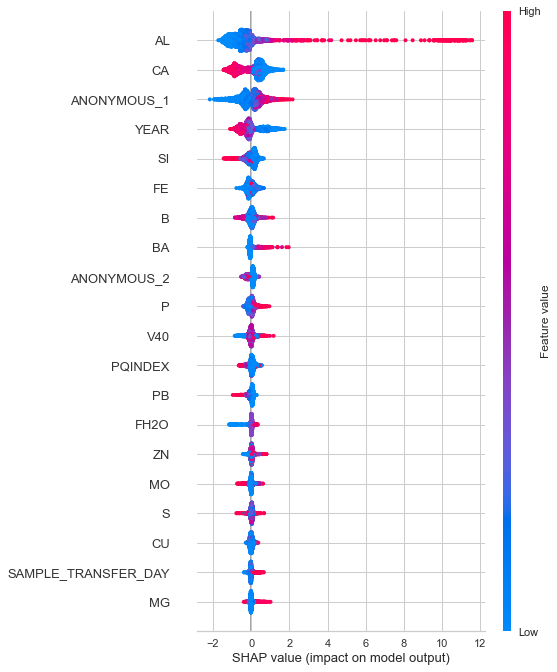

In [37]:
interpret_model(tuned_lgbm)

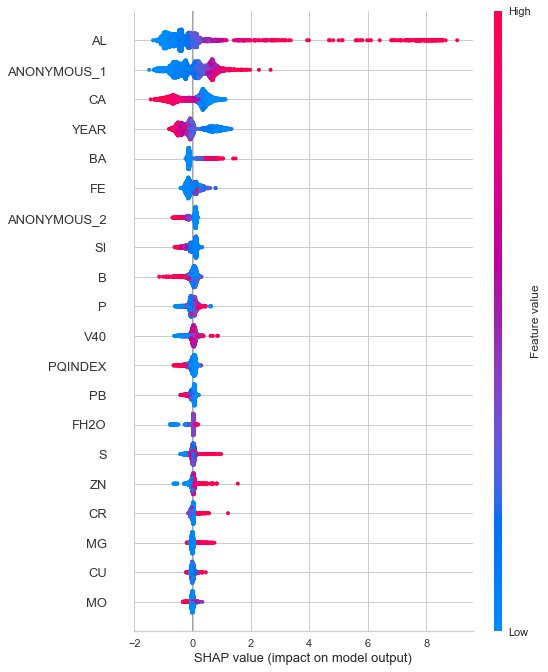

In [38]:
interpret_model(tuned_cat)

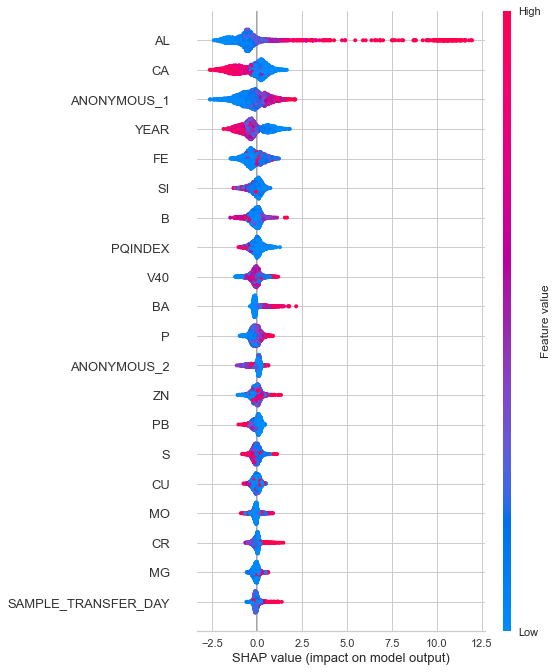

In [39]:
interpret_model(tuned_xgb)

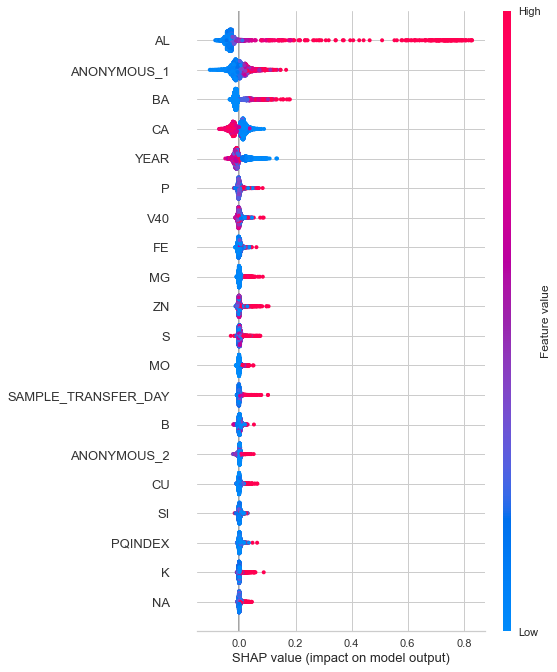

In [40]:
interpret_model(tuned_rf)

## **One Model**

- Metric : competition_metric 함수 사용

### **LGBM**

In [46]:
final_model = finalize_model(tuned_lgbm)
print(final_model)

# 예측
prediction = predict_model(final_model, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9564,0.8981,0.5560,0.8933,0.6854,0.6633,0.6849


F1 Score 0.6854
Macro F1 Score 0.831 

[[2562  107]
 [  16  134]]
None


### **CatBoost**

In [47]:
final_model = finalize_model(tuned_cat)
print(final_model)

# 예측
prediction = predict_model(final_model, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9571,0.9115,0.5560,0.9054,0.6889,0.6673,0.6903


F1 Score 0.6889
Macro F1 Score 0.8329 

[[2564  107]
 [  14  134]]
None


### **XGBoost**

In [48]:
final_model = finalize_model(tuned_xgb)
print(final_model)

# 예측
prediction = predict_model(final_model, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', ...)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9581,0.8978,0.5685,0.9073,0.6990,0.6778,0.6992


F1 Score 0.699
Macro F1 Score 0.8382 

[[2564  104]
 [  14  137]]
None


### **GBC**

In [49]:
final_model = finalize_model(tuned_gbc)
print(final_model)

# 예측
prediction = predict_model(final_model, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.09078773792371019, loss='deviance',
                           max_depth=9, max_features=0.6375498969038981,
                           max_leaf_nodes=None,
                           min_impurity_decrease=4.280175776427147e-08,
                           min_impurity_split=None, min_samples_leaf=2,
                           min_samples_split=6, min_weight_fraction_leaf=0.0,
                           n_estimators=105, n_iter_no_change=None,
                           presort='deprecated', random_state=42,
                           subsample=0.6162288583048221, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9585,0.9015,0.5685,0.9133,0.7008,0.6798,0.7019


F1 Score 0.7008
Macro F1 Score 0.8392 

[[2565  104]
 [  13  137]]
None


### **Random Forest**

In [50]:
final_model = finalize_model(tuned_rf)
print(final_model)

# 예측
prediction = predict_model(final_model, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9574,0.9003,0.5394,0.9353,0.6842,0.6631,0.6921


F1 Score 0.6842
Macro F1 Score 0.8307 

[[2569  111]
 [   9  130]]
None


### **Logistic Regression**

In [51]:
final_model = finalize_model(tuned_lr)
print(final_model)

# 예측
prediction = predict_model(final_model, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9557,0.8682,0.5353,0.9085,0.6736,0.6515,0.6779


F1 Score 0.6736
Macro F1 Score 0.8249 

[[2565  112]
 [  13  129]]
None


## **Soft Voting Classifier**

### **6개 (LGBM, CatBoost, XGBoost, GBC, Random Forest, Logistic Regression)**

In [52]:
blender_specific_s = blend_models(estimator_list = [tuned_lgbm, tuned_cat, tuned_xgb, tuned_gbc, tuned_rf, tuned_lr], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.8999,0.4815,0.9155,0.6311,0.6080,0.6441
1,0.9563,0.9027,0.5111,0.9583,0.6667,0.6456,0.6823
2,0.9519,0.8834,0.4815,0.9155,0.6311,0.6080,0.6441
3,0.9575,0.8970,0.5224,0.9589,0.6763,0.6557,0.6905
4,0.9569,0.9096,0.5000,0.9853,0.6634,0.6430,0.6854
Mean,0.9549,0.8985,0.4993,0.9467,0.6537,0.6320,0.6693
Std,0.0025,0.0087,0.0162,0.0273,0.0190,0.0201,0.0207


In [53]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9531,0.8994,0.4889,0.9296,0.6408,0.6183,0.6550
1,0.9569,0.9024,0.5185,0.9589,0.6731,0.6522,0.6877
2,0.9525,0.8822,0.4889,0.9167,0.6377,0.6148,0.6497
3,0.9582,0.8918,0.5299,0.9595,0.6827,0.6623,0.6959
4,0.9569,0.9106,0.5000,0.9853,0.6634,0.6430,0.6854
Mean,0.9555,0.8973,0.5052,0.9500,0.6595,0.6381,0.6747
Std,0.0023,0.0097,0.0164,0.0243,0.0177,0.0187,0.0187


In [55]:
# 전체 데이터로 마지막 학습을 진행
final_model_s = finalize_model(voting)
print(final_model_s)

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0, device='gpu',
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=42, reg_alpha=0.0,
                                             reg_lambda=0.0, si...
                              LogisticRegression(C=1.0, class_weight=None,
                            

In [57]:
# 예측
prediction = predict_model(final_model_s, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9581,0.9106,0.5560,0.9241,0.6943,0.6733,0.6984


F1 Score 0.6943
Macro F1 Score 0.8359 

[[2567  107]
 [  11  134]]
None


### **5개 (LGBM, CatBoost, XGBoost, GBC, Random Forest)**

In [58]:
blender_specific_s = blend_models(estimator_list = [tuned_lgbm, tuned_cat, tuned_xgb, tuned_gbc, tuned_rf], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.9000,0.4889,0.9041,0.6346,0.6113,0.6446
1,0.9563,0.9027,0.5185,0.9459,0.6699,0.6486,0.6823
2,0.9525,0.8841,0.4889,0.9167,0.6377,0.6148,0.6497
3,0.9594,0.8883,0.5373,0.9730,0.6923,0.6725,0.7066
4,0.9563,0.9097,0.4925,0.9851,0.6567,0.6361,0.6800
Mean,0.9553,0.8970,0.5052,0.9450,0.6582,0.6367,0.6727
Std,0.0028,0.0094,0.0195,0.0312,0.0213,0.0226,0.0229


In [59]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.8973,0.4889,0.9041,0.6346,0.6113,0.6446
1,0.9569,0.9025,0.5185,0.9589,0.6731,0.6522,0.6877
2,0.9525,0.8799,0.4889,0.9167,0.6377,0.6148,0.6497
3,0.9582,0.8850,0.5299,0.9595,0.6827,0.6623,0.6959
4,0.9563,0.9096,0.5000,0.9710,0.6601,0.6393,0.6797
Mean,0.9552,0.8949,0.5052,0.9420,0.6576,0.6360,0.6715
Std,0.0025,0.0110,0.0164,0.0265,0.0190,0.0201,0.0206


In [62]:
# 전체 데이터로 마지막 학습을 진행
final_model_s = finalize_model(voting)

print(final_model_s)

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0, device='gpu',
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=42, reg_alpha=0.0,
                                             reg_lambda=0.0, si...
                                                     max_depth=None,
                                  

In [63]:
# 예측
prediction = predict_model(final_model_s, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9581,0.9131,0.5602,0.9184,0.6959,0.6748,0.6987


F1 Score 0.6959
Macro F1 Score 0.8367 

[[2566  106]
 [  12  135]]
None


### CatBoost, XGBoost, GBC

In [64]:
blender_specific_s = blend_models(estimator_list = [tuned_cat, tuned_xgb, tuned_gbc], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9512,0.8969,0.4889,0.8919,0.6316,0.6078,0.6395
1,0.9569,0.9010,0.5185,0.9589,0.6731,0.6522,0.6877
2,0.9519,0.8813,0.4963,0.8933,0.6381,0.6146,0.6452
3,0.9588,0.8931,0.5373,0.9600,0.6890,0.6688,0.7012
4,0.9563,0.8989,0.5075,0.9577,0.6634,0.6424,0.6796
Mean,0.9550,0.8942,0.5097,0.9324,0.6590,0.6372,0.6706
Std,0.0030,0.0070,0.0171,0.0325,0.0215,0.0229,0.0242


In [65]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9512,0.8972,0.4889,0.8919,0.6316,0.6078,0.6395
1,0.9569,0.9007,0.5185,0.9589,0.6731,0.6522,0.6877
2,0.9519,0.8817,0.4963,0.8933,0.6381,0.6146,0.6452
3,0.9588,0.8931,0.5373,0.9600,0.6890,0.6688,0.7012
4,0.9563,0.8990,0.5075,0.9577,0.6634,0.6424,0.6796
Mean,0.9550,0.8943,0.5097,0.9324,0.6590,0.6372,0.6706
Std,0.0030,0.0068,0.0171,0.0325,0.0215,0.0229,0.0242


In [66]:
# 전체 데이터로 마지막 학습을 진행
final_model_s = finalize_model(voting)

print(final_model_s)

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x0000025B572DD670>),
                             ('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=0, grow_policy=...
                                                         min_impurity_decrease=4.280175776427147e-08,
                                                         min_impurity_split=None,
   

In [68]:
# 예측
prediction = predict_model(final_model_s, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9589,0.9101,0.5685,0.9195,0.7026,0.6818,0.7046


F1 Score 0.7026
Macro F1 Score 0.8402 

[[2566  104]
 [  12  137]]
None


### LGBM, CatBoost, GBC 

In [69]:
blender_specific_s = blend_models(estimator_list = [tuned_lgbm, tuned_cat, tuned_gbc], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.9007,0.4889,0.9041,0.6346,0.6113,0.6446
1,0.9563,0.9010,0.5185,0.9459,0.6699,0.6486,0.6823
2,0.9519,0.8853,0.4889,0.9041,0.6346,0.6113,0.6446
3,0.9601,0.8965,0.5373,0.9863,0.6957,0.6763,0.7122
4,0.9563,0.9009,0.4925,0.9851,0.6567,0.6361,0.6800
Mean,0.9553,0.8969,0.5052,0.9451,0.6583,0.6367,0.6727
Std,0.0031,0.0060,0.0195,0.0365,0.0230,0.0245,0.0256


In [70]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.9006,0.4889,0.9041,0.6346,0.6113,0.6446
1,0.9563,0.9004,0.5185,0.9459,0.6699,0.6486,0.6823
2,0.9525,0.8854,0.4889,0.9167,0.6377,0.6148,0.6497
3,0.9594,0.8971,0.5373,0.9730,0.6923,0.6725,0.7066
4,0.9569,0.9009,0.5000,0.9853,0.6634,0.6430,0.6854
Mean,0.9554,0.8969,0.5067,0.9450,0.6596,0.6380,0.6737
Std,0.0028,0.0059,0.0187,0.0312,0.0214,0.0227,0.0233


In [71]:
# 전체 데이터로 마지막 학습을 진행
final_model_s = finalize_model(voting)

print(final_model_s)

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0, device='gpu',
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=42, reg_alpha=0.0,
                                             reg_lambda=0.0, si...
                                                         min_samples_leaf=2,
                          

In [72]:
# 예측
prediction = predict_model(final_model_s, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9574,0.9087,0.5602,0.9060,0.6923,0.6708,0.6932


F1 Score 0.6923
Macro F1 Score 0.8347 

[[2564  106]
 [  14  135]]
None


### LGBM, GBC, RF 

In [73]:
blender_specific_s = blend_models(estimator_list = [tuned_lgbm, tuned_gbc, tuned_rf], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.8940,0.4889,0.9041,0.6346,0.6113,0.6446
1,0.9563,0.8992,0.5111,0.9583,0.6667,0.6456,0.6823
2,0.9525,0.8775,0.4889,0.9167,0.6377,0.6148,0.6497
3,0.9588,0.8796,0.5299,0.9726,0.6860,0.6660,0.7013
4,0.9563,0.9108,0.4925,0.9851,0.6567,0.6361,0.6800
Mean,0.9552,0.8922,0.5023,0.9474,0.6563,0.6347,0.6716
Std,0.0026,0.0124,0.0161,0.0316,0.0190,0.0202,0.0213


In [74]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.8974,0.4889,0.9041,0.6346,0.6113,0.6446
1,0.9557,0.8996,0.5111,0.9452,0.6635,0.6420,0.6769
2,0.9525,0.8824,0.4889,0.9167,0.6377,0.6148,0.6497
3,0.9594,0.8849,0.5299,0.9861,0.6893,0.6697,0.7069
4,0.9563,0.9104,0.4925,0.9851,0.6567,0.6361,0.6800
Mean,0.9552,0.8949,0.5023,0.9474,0.6564,0.6348,0.6716
Std,0.0027,0.0103,0.0161,0.0339,0.0198,0.0211,0.0226


In [75]:
# 전체 데이터로 마지막 학습을 진행
final_model_s = finalize_model(voting)

print(final_model_s)

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0, device='gpu',
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=42, reg_alpha=0.0,
                                             reg_lambda=0.0, si...
                                                     max_samples=None,
                                

In [76]:
# 예측
prediction = predict_model(final_model_s, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9581,0.9098,0.5643,0.9128,0.6974,0.6763,0.6989


F1 Score 0.6974
Macro F1 Score 0.8375 

[[2565  105]
 [  13  136]]
None


### LGBM, XGBoost, GBC 

In [77]:
blender_specific_s = blend_models(estimator_list = [tuned_lgbm, tuned_xgb, tuned_gbc], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.8948,0.4889,0.9041,0.6346,0.6113,0.6446
1,0.9563,0.9004,0.5185,0.9459,0.6699,0.6486,0.6823
2,0.9525,0.8807,0.4889,0.9167,0.6377,0.6148,0.6497
3,0.9588,0.8948,0.5373,0.9600,0.6890,0.6688,0.7012
4,0.9563,0.8956,0.4925,0.9851,0.6567,0.6361,0.6800
Mean,0.9552,0.8932,0.5052,0.9424,0.6576,0.6359,0.6716
Std,0.0026,0.0066,0.0195,0.0292,0.0203,0.0214,0.0213


In [78]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9525,0.8911,0.4963,0.9054,0.6411,0.6180,0.6502
1,0.9576,0.9016,0.5259,0.9595,0.6794,0.6588,0.6931
2,0.9519,0.8799,0.4963,0.8933,0.6381,0.6146,0.6452
3,0.9575,0.8925,0.5373,0.9351,0.6825,0.6615,0.6907
4,0.9550,0.8970,0.4925,0.9565,0.6502,0.6288,0.6686
Mean,0.9549,0.8924,0.5097,0.9300,0.6583,0.6363,0.6696
Std,0.0024,0.0073,0.0183,0.0266,0.0190,0.0200,0.0199


In [79]:
# 전체 데이터로 마지막 학습을 진행
final_model_s = finalize_model(voting)

print(final_model_s)

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0, device='gpu',
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=42, reg_alpha=0.0,
                                             reg_lambda=0.0, si...
                                                         min_impurity_decrease=4.280175776427147e-08,
 

In [80]:
# 예측
prediction = predict_model(final_model_s, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9589,0.9029,0.5768,0.9085,0.7056,0.6846,0.7051


F1 Score 0.7056
Macro F1 Score 0.8417 

[[2564  102]
 [  14  139]]
None


### LGBM, XGBoost, RandomForest

In [81]:
blender_specific_s = blend_models(estimator_list = [tuned_lgbm, tuned_xgb, tuned_rf], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.8934,0.4741,0.9275,0.6275,0.6046,0.6437
1,0.9569,0.9001,0.5185,0.9589,0.6731,0.6522,0.6877
2,0.9519,0.8749,0.4889,0.9041,0.6346,0.6113,0.6446
3,0.9582,0.8821,0.5299,0.9595,0.6827,0.6623,0.6959
4,0.9569,0.9106,0.5000,0.9853,0.6634,0.6430,0.6854
Mean,0.9552,0.8922,0.5023,0.9471,0.6562,0.6347,0.6715
Std,0.0027,0.0127,0.0200,0.0282,0.0216,0.0228,0.0226


In [82]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9506,0.8961,0.4741,0.9014,0.6214,0.5976,0.6331
1,0.9569,0.8999,0.5259,0.9467,0.6762,0.6551,0.6877
2,0.9519,0.8796,0.4889,0.9041,0.6346,0.6113,0.6446
3,0.9588,0.8860,0.5299,0.9726,0.6860,0.6660,0.7013
4,0.9569,0.9092,0.5000,0.9853,0.6634,0.6430,0.6854
Mean,0.9550,0.8942,0.5037,0.9420,0.6563,0.6346,0.6704
Std,0.0032,0.0104,0.0214,0.0344,0.0246,0.0260,0.0266


In [83]:
# 전체 데이터로 마지막 학습을 진행
final_model_s = finalize_model(voting)

print(final_model_s)

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0, device='gpu',
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=42, reg_alpha=0.0,
                                             reg_lambda=0.0, si...
                                                     max_samples=None,
                                

In [84]:
# 예측
prediction = predict_model(final_model_s, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9578,0.9093,0.5602,0.9122,0.6941,0.6728,0.6959


F1 Score 0.6941
Macro F1 Score 0.8357 

[[2565  106]
 [  13  135]]
None


### XGBoost, GBC, RandomForest

In [85]:
blender_specific_s = blend_models(estimator_list = [tuned_xgb, tuned_gbc, tuned_rf], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.8897,0.4889,0.9041,0.6346,0.6113,0.6446
1,0.9582,0.8996,0.5259,0.9726,0.6827,0.6624,0.6985
2,0.9512,0.8660,0.4815,0.9028,0.6280,0.6045,0.6389
3,0.9575,0.8777,0.5299,0.9467,0.6794,0.6586,0.6906
4,0.9563,0.9092,0.5000,0.9710,0.6601,0.6393,0.6797
Mean,0.9550,0.8884,0.5052,0.9394,0.6570,0.6352,0.6704
Std,0.0029,0.0153,0.0195,0.0308,0.0224,0.0238,0.0243


In [86]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9519,0.8898,0.4889,0.9041,0.6346,0.6113,0.6446
1,0.9582,0.8996,0.5259,0.9726,0.6827,0.6624,0.6985
2,0.9519,0.8660,0.4889,0.9041,0.6346,0.6113,0.6446
3,0.9575,0.8783,0.5299,0.9467,0.6794,0.6586,0.6906
4,0.9563,0.9092,0.5000,0.9710,0.6601,0.6393,0.6797
Mean,0.9552,0.8885,0.5067,0.9397,0.6583,0.6366,0.6716
Std,0.0028,0.0153,0.0178,0.0305,0.0208,0.0221,0.0229


In [87]:
# 전체 데이터로 마지막 학습을 진행
final_model_s = finalize_model(voting)

print(final_model_s)

VotingClassifier(estimators=[('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=0, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=...
                                                     max_depth=None,
                                               

In [89]:
# 예측
prediction = predict_model(final_model_s, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9585,0.9092,0.5643,0.9189,0.6992,0.6783,0.7016


F1 Score 0.6992
Macro F1 Score 0.8385 

[[2566  105]
 [  12  136]]
None


### XGBoost, GBC

In [90]:
blender_specific_s = blend_models(estimator_list = [tuned_xgb, tuned_gbc], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9531,0.8846,0.5037,0.9067,0.6476,0.6247,0.6558
1,0.9569,0.8995,0.5259,0.9467,0.6762,0.6551,0.6877
2,0.9525,0.8749,0.5037,0.8947,0.6445,0.6212,0.6508
3,0.9575,0.8874,0.5299,0.9467,0.6794,0.6586,0.6906
4,0.9537,0.8940,0.4925,0.9296,0.6439,0.6216,0.6577
Mean,0.9548,0.8881,0.5111,0.9249,0.6583,0.6363,0.6685
Std,0.0021,0.0084,0.0143,0.0210,0.0160,0.0169,0.0170


In [91]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9525,0.8840,0.4963,0.9054,0.6411,0.6180,0.6502
1,0.9569,0.8993,0.5259,0.9467,0.6762,0.6551,0.6877
2,0.9519,0.8745,0.5037,0.8831,0.6415,0.6178,0.6459
3,0.9582,0.8870,0.5373,0.9474,0.6857,0.6651,0.6959
4,0.9537,0.8936,0.4925,0.9296,0.6439,0.6216,0.6577
Mean,0.9546,0.8877,0.5112,0.9224,0.6577,0.6355,0.6675
Std,0.0025,0.0085,0.0175,0.0249,0.0193,0.0204,0.0204


In [92]:
# 전체 데이터로 마지막 학습을 진행
final_model_s = finalize_model(voting)

print(final_model_s)

VotingClassifier(estimators=[('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=0, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=...
                                                         min_impurity_decrease=4.280175776427147e-08,
              

In [93]:
# 예측
prediction = predict_model(final_model_s, data=test, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9585,0.9026,0.5726,0.9079,0.7023,0.6812,0.7022


F1 Score 0.7023
Macro F1 Score 0.84 

[[2564  103]
 [  14  138]]
None


## Final Modeling

**Test F1 Score는 LGBM, XGBoost, GBC를 Soft Voting한 모델이 0.7056으로 가장 높았기에 최종 모델로 결정한다. 전체 데이터셋으로 다시 학습시킨다**

In [94]:
train = pd.read_csv('C:/Users/cdbre/Downloads/trainset.csv')

train = train[['AL','CA','BA','B','SI','P','S','FH2O','NA','PB','SAMPLE_TRANSFER_DAY','MG','K','FOXs',
               'ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR','Y_LABEL']]

train1, test1 = train_test_split(train, stratify=train.Y_LABEL, test_size=0.2, random_state=42)

In [96]:
# pycaret은 수치형 데이터 결측치를 디폴트로 평균으로 대체해서 미리 채워줘야될듯..
clf = setup(data = train,  
            target = 'Y_LABEL',  # 타겟 데이터 설정
            ordinal_features = {'YEAR' : ['2007','2008','2009','2010','2011','2012','2013','2014',
                                          '2015','2016','2017','2018','2019','2020','2021','2022']},  # YEAR 칼럼은 순서형
            numeric_features = ['AL', 'CA', 'BA', 'B', 'SI', 'P', 'S', 'FH2O', 'NA', 'PB','SAMPLE_TRANSFER_DAY', 'MG', 'K', 
                                'FOXs', 'ANONYMOUS_1', 'FE','ANONYMOUS_2', 'ZN', 'V40', 'PQINDEX', 'NI', 'CU', 'MO', 'CR'], 
            use_gpu = True,
            normalize=True, normalize_method = 'robust',  # 수치형 변수는 이상치가 많아 Robust Scaling 적용
            data_split_stratify=True, fold=5,
            session_id = 42)

,Description,Value
0,session_id,42
1,Target,Y_LABEL
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(14095, 26)"
5,Missing Values,False
6,Numeric Features,24
7,Categorical Features,1
8,Ordinal Features,True
9,High Cardinality Features,False


In [98]:
lgbm = create_model('lightgbm', cross_validation = False)
xgb = create_model('xgboost', cross_validation = False)
gbc = create_model('gbc', cross_validation = False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9548,0.8892,0.5208,0.9126,0.6631,0.6409,0.6699


In [99]:
tuned_lgbm = tune_model(lgbm, optimize='F1', n_iter=5, search_library='optuna', choose_better=True)
tuned_xgb = tune_model(lgbm, optimize='F1', n_iter=5, search_library='optuna', choose_better=True)
tuned_gbc = tune_model(lgbm, optimize='F1', n_iter=5, search_library='optuna', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9458,0.8817,0.4615,0.8298,0.5932,0.5666,0.5947
1,0.9589,0.9073,0.5714,0.9143,0.7033,0.6825,0.7043
2,0.9559,0.8928,0.5119,0.9451,0.6641,0.6427,0.6775
3,0.9488,0.8472,0.4345,0.9241,0.5911,0.5675,0.6139
4,0.9518,0.8844,0.4852,0.9111,0.6332,0.6100,0.6448
Mean,0.9523,0.8827,0.4929,0.9049,0.6370,0.6139,0.6470
Std,0.0047,0.0199,0.0469,0.0394,0.0428,0.0446,0.0401


In [100]:
print(tuned_lgbm, '\n')
print(tuned_xgb, '\n')
print(tuned_gbc)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0) 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0) 

LGBMClassifier(boost

In [101]:
blender_specific_s = blend_models(estimator_list = [tuned_lgbm, tuned_xgb, tuned_gbc], 
                                  optimize = 'F1', method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9529,0.8953,0.4970,0.9130,0.6437,0.6208,0.6539
1,0.9620,0.9188,0.5893,0.9429,0.7253,0.7060,0.7286
2,0.9589,0.9018,0.5417,0.9579,0.6920,0.6718,0.7033
3,0.9508,0.8649,0.4524,0.9383,0.6104,0.5876,0.6325
4,0.9539,0.8869,0.5148,0.9062,0.6566,0.6339,0.6631
Mean,0.9557,0.8935,0.5190,0.9317,0.6656,0.6440,0.6763
Std,0.0041,0.0177,0.0456,0.0192,0.0397,0.0411,0.0348


In [102]:
voting = tune_model(blender_specific_s,
                    optimize = 'F1',
                    choose_better = True,
                    n_iter = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9529,0.8953,0.4970,0.9130,0.6437,0.6208,0.6539
1,0.9620,0.9188,0.5893,0.9429,0.7253,0.7060,0.7286
2,0.9589,0.9018,0.5417,0.9579,0.6920,0.6718,0.7033
3,0.9508,0.8650,0.4524,0.9383,0.6104,0.5876,0.6325
4,0.9539,0.8869,0.5148,0.9062,0.6566,0.6339,0.6631
Mean,0.9557,0.8936,0.5190,0.9317,0.6656,0.6440,0.6763
Std,0.0041,0.0177,0.0456,0.0192,0.0397,0.0411,0.0348


In [103]:
final_model_s = finalize_model(voting)

In [105]:
# 모델 저장하기
save_model(final_model_s,'C:/Users/cdbre/OneDrive/바탕 화면/데이콘용/teacher_final_model.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['AL', 'CA', 'BA', 'B',
                                                           'SI', 'P', 'S',
                                                           'FH2O', 'NA', 'PB',
                                                           'SAMPLE_TRANSFER_DAY',
                                                           'MG', 'K', 'FOXs',
                                                           'ANONYMOUS_1', 'FE',
                                                           'ANONYMOUS_2', 'ZN',
                                                           'V40', 'PQINDEX',
                                                   

In [109]:
prediction = predict_model(final_model_s, data=train, raw_score=True)
prediction.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9812,0.9990,0.7797,1.0000,0.8762,0.8662,0.8741


,AL,CA,BA,B,SI,P,S,FH2O,NA,PB,...,V40,PQINDEX,NI,CU,MO,CR,Y_LABEL,Label,Score_0,Score_1
0,3,3059,0,93,427,1951,21370,13.0,16,0,...,154.0,8504,6,78,1,13,0,0,0.9949,0.0051
1,2,2978,0,19,0,572,1117,13.0,1,2,...,44.0,19,0,31,0,0,0,0,0.9958,0.0042
2,110,17,1,1,0,328,1334,13.0,2,0,...,72.6,17,0,2,0,1,1,1,0.0017,0.9983
3,8,1960,0,3,1,906,21774,13.0,0,1,...,133.3,44,0,1,0,0,0,0,0.7446,0.2554
4,1,71,0,157,2,309,18470,13.0,2,0,...,133.1,217,0,0,0,0,0,0,0.9915,0.0085


In [110]:
# csv 파일 저장
prediction.to_csv('C:/Users/cdbre/OneDrive/바탕 화면/데이콘용/teacher_train.csv', index=False)

In [107]:
# 이전 test로 예측
prediction = predict_model(final_model_s, data=test1, raw_score=True)

print(competition_metric(prediction.Label, prediction.Y_LABEL))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9816,0.9989,0.7842,1.0000,0.8791,0.8692,0.8768


F1 Score 0.8791
Macro F1 Score 0.9345 

[[2578   52]
 [   0  189]]
None
